In [1]:
%%HTML 
<style>.container{width:100%;}</style>

Dieses Notebook hängt vom Notebook `Ordered-Sets` ab. Es hängt auch von Dateien im Ordner `Aux` ab, die aus [diesen Vorlesungsunterlagen](https://github.com/karlstroetmann/Logic/tree/master/Python "K. Stroetmann (2020): Logic/Python, GitHub") abgeleitet wurden; dem Notebook `N-Queens` und der Datei `davisPutnam.py`, wobei letztere von `N-Queens` importiert wird. Aus [diesen Vorlesungsunterlagen](https://github.com/karlstroetmann/Algorithms/tree/master/Python "K. Stroetmann (2020): Algorithms/Python, GitHub") sind die Notebooks `Set` und `HashMap`, die auch hier verwendet werden.

Help on class set in module builtins:

class set(object)
 |  set() -> new empty set object
 |  set(iterable) -> new set object
 |  
 |  Build an unordered collection of unique elements.
 |  
 |  Methods defined here:
 |  
 |  __and__(self, value, /)
 |      Return self&value.
 |  
 |  __contains__(...)
 |      x.__contains__(y) <==> y in x.
 |  
 |  __eq__(self, value, /)
 |      Return self==value.
 |  
 |  __ge__(self, value, /)
 |      Return self>=value.
 |  
 |  __getattribute__(self, name, /)
 |      Return getattr(self, name).
 |  
 |  __gt__(self, value, /)
 |      Return self>value.
 |  
 |  __iand__(self, value, /)
 |      Return self&=value.
 |  
 |  __init__(self, /, *args, **kwargs)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  __ior__(self, value, /)
 |      Return self|=value.
 |  
 |  __isub__(self, value, /)
 |      Return self-=value.
 |  
 |  __iter__(self, /)
 |      Implement iter(self).
 |  
 |  __ixor__(self, value, /)
 |      Re

Autosave disabled


andre


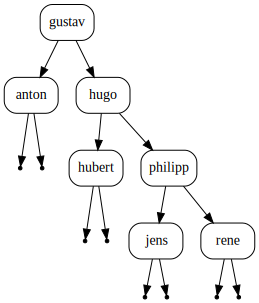

anton


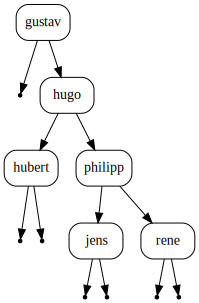

gustav


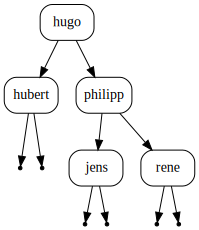

hubert


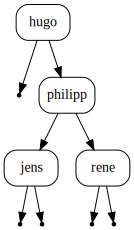

hugo


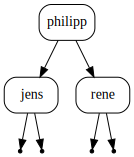

jens


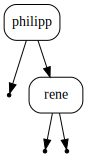

philipp


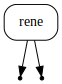

rene


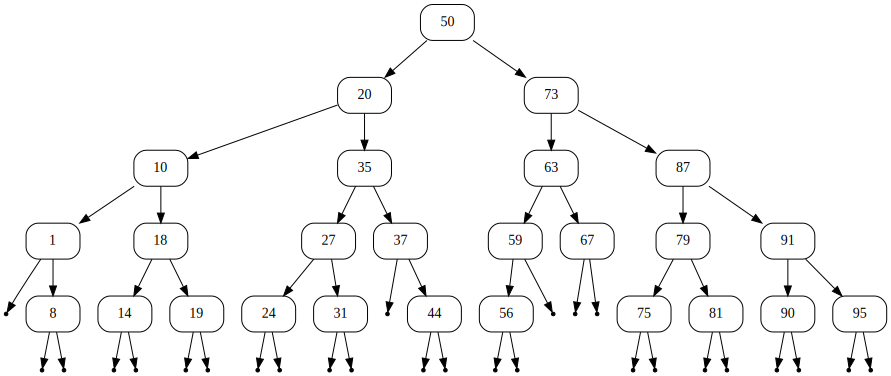

1 8 10 14 18 19 20 24 27 31 35 37 44 50 56 59 63 67 73 75 79 81 87 90 91 95 

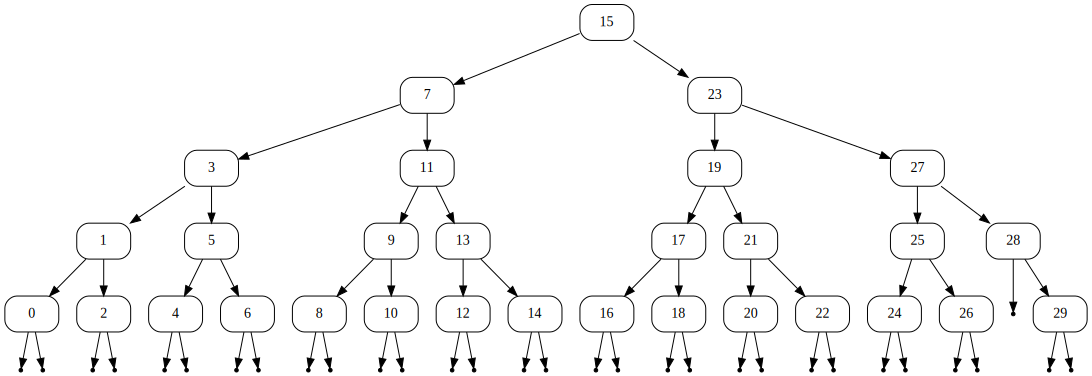

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 

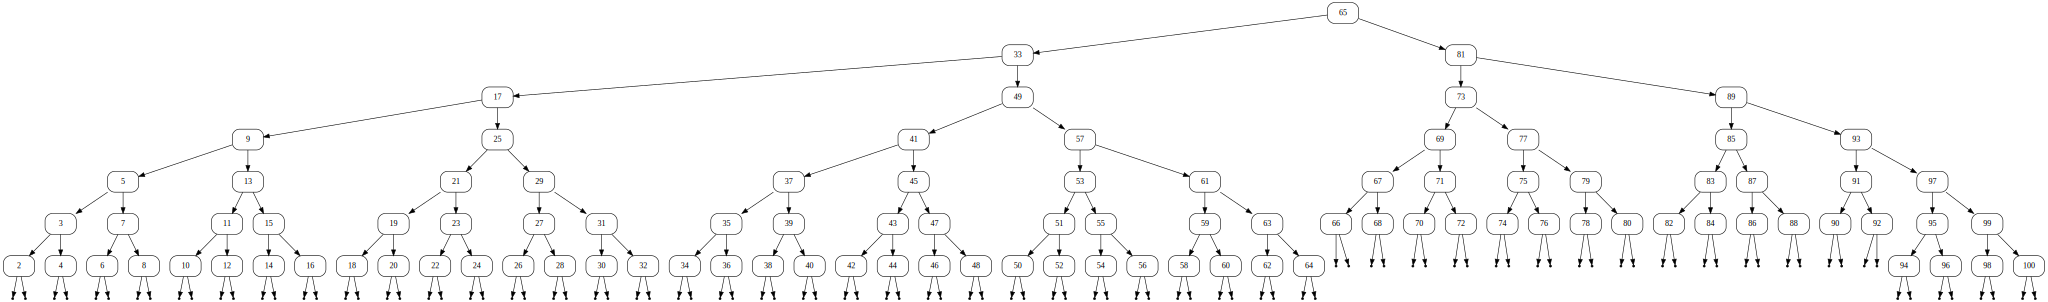

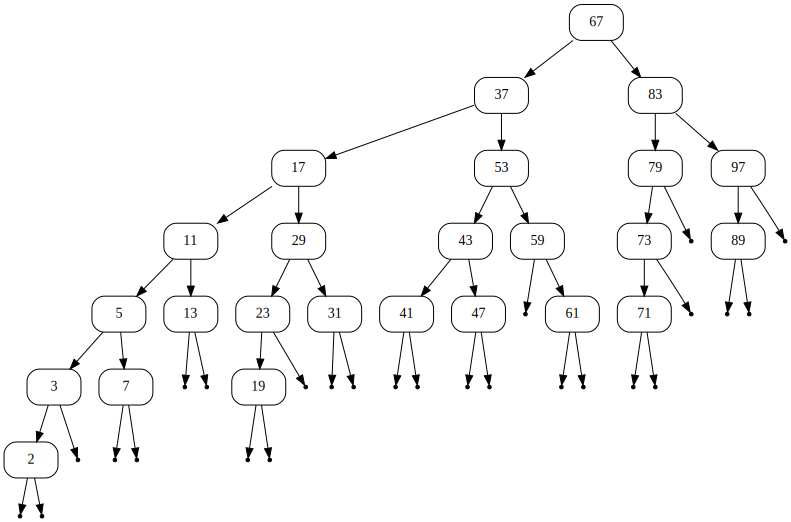

2 3 5 7 11 13 17 19 23 29 31 37 41 43 47 53 59 61 67 71 73 79 83 89 97 

Autosave disabled


mEntries = 6 mSize = 3
mEntries = 14 mSize = 7


In [2]:
%run Ordered-Sets.ipynb
%run Aux/N-Queens.ipynb
%run Aux/Set.ipynb
%run Aux/HashMap.ipynb

Wir benötigen auch `deque` aus den zur Standard Library gehörenden `collections`.

In [3]:
from collections import deque

# Performance

## Anwendungsbeispiel: Sieb des Eratosthenes

Als Anwendungsbeispiel benutzen wir das `OrderedSet`, um alle Primzahlen bis zu einem Maximum abzulegen. Die Primzahlen werden dabei mit dem Sieb des Eratosthenes berechnet. Die Implementierung ist sehr einfach gehalten und hat Raum für Optimierungen, aber das ist für den Vergleich mit anderen Implementierungen unproblematisch, solange wir diese genauso verwenden.

In [4]:
def splay_primes(n):
    primes = OrderedSet(range(2, n + 1))
    for i in range(2, n + 1):
        for j in range(2 * i, n + 1, i):
            primes.discard(j)
    return primes

Wir berechnen probeweise die Primzahlen bis 100.

In [5]:
print(splay_primes(100))

OrderedSet([2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67, 71, 73, 79, 83, 89, 97])


Wir wiederholen die Implementierung mit dem eingebauten `set`.

In [6]:
def set_primes(n):
    primes = set(range(2, n + 1))
    for i in range(2, n + 1):
        for j in range(2 * i, n + 1, i):
            primes.discard(j)
    return primes

In [7]:
print(set_primes(100))

{2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67, 71, 73, 79, 83, 89, 97}


Wir implementieren das Sieb des Eratosthenes auch für das importierte `Set` in der Implementierung von [Stroetmann](https://github.com/karlstroetmann/Algorithms/tree/master/Python "K. Stroetmann (2020): Algorithms/Python, GitHub"), welche auf *AVL-Bäumen* basiert.

In [8]:
def avl_primes(n):
    primes = Set()
    for i in range(2, n + 1):
        primes.insert(i)
    for i in range(2, n + 1):
        for j in range(2 * i, n + 1, i):
            primes.delete(j)
    return primes

Um auch diese Mengen ausgeben zu können, implementieren wir `__iter__` ähnlich wie beim `OrderedSet`. Wir kopieren zur eigentlichen Ausgabe `__repr__` direkt von `OrderedSet`.

In [9]:
def __iter__(self):
    stack = deque()
    tree = self
    while stack or tree is not None:
        if tree is not None:
            stack.append(tree)
            tree = tree.mLeft
            continue
        tree = stack.pop()
        if tree.mKey is not None:
            yield tree.mKey
        tree = tree.mRight

Set.__iter__ = __iter__
del __iter__
Set.__repr__ = OrderedSet.__repr__

In [10]:
print(avl_primes(100))

Set([2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67, 71, 73, 79, 83, 89, 97])


Wir betrachten auch eine Implementierung auf Basis von Hashtabellen, aber in Python geschrieben, nämlich `HashTable`, ebenfalls von [Stroetmann](https://github.com/karlstroetmann/Algorithms/tree/master/Python "K. Stroetmann (2020): Algorithms/Python, GitHub").

Wir überschreiben dabei seine Definition von `hash_code`, die nur mit Strings funktioniert, indem wir einfach `hash` aufrufen. Dies ist kein vollständiger Ersatz, da wir keine geänderten Hashwerte anbieten, wenn der `HashTable` *overcrowded* ist; es genügt aber für unsere Zwecke. Der `HashTable` ist eigentlich ein Dictionary und keine Menge, dieses Problem beseitigen wir, indem wir einfach immer `True` als Wert speichern.

In [11]:
def hash_code(value, _):
    return hash(value)

def hash_primes(n):
    primes = HashTable(n + 1)
    for i in range(2, n + 1):
        primes.insert(i, True)
    for i in range(2, n + 1):
        for j in range(2 * i, n + 1, i):
            primes.delete(j)
    return primes

Wir implementieren auch ein `__init__` zur Stringdarstellung von `HashTables`, wobei wir alle belegten Schlüssel anzeigen, und übernehmen wieder `__repr__` von `OrderedSet`.

In [12]:
def __iter__(self):
    for x in self.mArray:
        if x:
            yield x[0][0]

HashTable.__iter__ = __iter__
del __iter__
HashTable.__repr__ = OrderedSet.__repr__

In [13]:
print(hash_primes(100))

HashTable([2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67, 71, 73, 79, 83, 89, 97])


Wir betrachten nun vergleichend die Ausführungszeiten der Varianten.

In [14]:
def fmt_against_splay(splay_time, other_time):
    if splay_time > other_time:
        return f"Splaying was {round(splay_time / other_time, 2)} times slower"
    else:
        return f"Splaying was {round(other_time / splay_time, 2)} times faster"

n = 10**4

# Ignore missing whitespace around operator because this is actually a flag
# Ignore syntax error that flake8 sees due to a compatibility issue
splay_times = %timeit -o splay_primes(n)  # noqa: E225, E999
splay_time = splay_times.best

set_times = %timeit -o set_primes(n)  # noqa: E225
set_time = set_times.best

avl_times = %timeit -o avl_primes(n)  # noqa: E225
avl_time = avl_times.best

hash_times = %timeit -o hash_primes(n)  # noqa: E225
hash_time = hash_times.best

print(f"Native sets: {fmt_against_splay(splay_time, set_time)}")
print(f"AVL sets: {fmt_against_splay(splay_time, avl_time)}")
print(f"Python hash maps: {fmt_against_splay(splay_time, hash_time)}")

528 ms ± 74.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
10.1 ms ± 741 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
446 ms ± 7.59 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
53.3 ms ± 704 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
Native sets: Splaying was 46.69 times slower
AVL sets: Splaying was 1.03 times slower
Python hash maps: Splaying was 8.58 times slower


Dabei ist zu beachten, dass wir zu diesem Zeitpunkt im Fall der nativen `set`s die Python-Implementierung mit einer C-Implementierung vergleichen.

## Anwendungsbeispiel: $n$-Damen-Problem

In einem weiteren Anwendungsbeispiel benutzen wir die geordneten Mengen, um den Algorithmus von Davis und Putnam in der Implementierung von [Stroetmann](https://github.com/karlstroetmann/Logic/tree/master/Python "K. Stroetmann (2020): Logic/Python, GitHub") zu implementieren. Damit werden wir das $n$-Damen-Problem lösen, welches als aussagenlogisches Problem aufgefasst wird (Implementierung in der gleichen Quelle). Beim $n$-Damen-Problem ist das Ziel, $n$ Damen auf ein $n \times n$-Schachbrett zu platzieren, sodass keine Dame eine andere Dame gemäß den Regeln des Schachspiels bedroht.

Wir implementieren dafür zunächst alle Methoden des Algorithmus von Davis und Putnam parallel zur existierenden Implementierung, wobei wir das Präfix `splay` benutzen.

In [15]:
def splaySelectVariable(Clauses, Forbidden):
    return dp.arb(OrderedSet([dp.extractVariable(L)
                              for C in Clauses for L in C]) - Forbidden)

def splayReduce(Clauses, l):
    lBar = dp.complement(l)
    return OrderedSet([C - OrderedSet([lBar]) for C in Clauses if lBar in C]) \
        | OrderedSet([C for C in Clauses if lBar not in C and l not in C]) \
        | OrderedSet([OrderedFrozenset([l])])

def splaySaturate(Clauses):
    S = Clauses.copy()
    Units = OrderedSet([C for C in S if len(C) == 1])
    Used = OrderedSet()
    while len(Units) > 0:
        unit = Units.pop()
        Used |= OrderedSet([unit])
        l = dp.arb(unit)  # noqa E471
        S = splayReduce(S, l)
        Units = OrderedSet([C for C in S if len(C) == 1]) - Used
    return S

def splaySolve(Clauses, Variables):
    S = splaySaturate(Clauses)
    empty = OrderedFrozenset()
    Falsum = OrderedSet([empty])
    if empty in S:
        return Falsum
    if all(len(C) == 1 for C in S):
        return S
    p = splaySelectVariable(S, Variables)
    negP = dp.complement(p)
    Result = splaySolve(S | OrderedSet([OrderedFrozenset([p])]),
                        Variables | OrderedSet([p]))
    if Result != Falsum:
        return Result
    return splaySolve(S | OrderedSet([OrderedFrozenset([negP])]),
                      Variables | OrderedSet([p]))

Auch reimplementieren wir die nötigen Methoden für die Spezifikation des $n$-Damen-Problems.

In [16]:
def splayAtMostOne(S):
    return OrderedSet([OrderedFrozenset([('¬', p), ('¬', q)]) for p in S
                       for q in S
                       if p != q])

def splayAtMostOneInRow(row, n):
    return splayAtMostOne(OrderedSet([var(row, col) for col in range(1, n+1)]))

def splayOneInColumn(col, n):
    return OrderedSet([OrderedFrozenset([var(row, col)
                                         for row in range(1, n+1)])])

def splayAtMostOneInFallingDiagonal(k, n):
    S = OrderedSet([var(row, col) for row in range(1, n+1)
                    for col in range(1, n+1)
                    if row - col == k])
    return splayAtMostOne(S)

def splayAtMostOneInRisingDiagonal(k, n):
    S = OrderedSet([var(row, col) for row in range(1, n+1)
                    for col in range(1, n+1)
                    if row + col == k])
    return splayAtMostOne(S)

def splayAllClauses(n):
    All = [splayAtMostOneInRow(row, n) for row in range(1, n+1)] \
        + [splayAtMostOneInRisingDiagonal(k, n) for k in range(3, (2*n-1)+1)] \
        + [splayAtMostOneInFallingDiagonal(k, n)
           for k in range(-(n-2), (n-2)+1)] \
        + [splayOneInColumn(col, n) for col in range(1, n+1)]
    return OrderedSet([clause for S in All for clause in S])

def splayQueens(n):
    Clauses = splayAllClauses(n)
    Solution = splaySolve(Clauses, OrderedSet())
    if Solution != OrderedSet([OrderedFrozenset()]):
        return Solution
    else:
        print(f'The problem is not solvable for {n} queens!')

def splayPrintBoard(I, n):
    if I == OrderedSet([OrderedFrozenset()]):  # noqa E471
        return
    print("-" * (8*n+1))
    for row in range(1, n+1):
        printEmptyLine(n)
        line = "|"
        for col in range(1, n+1):
            if OrderedFrozenset([var(row, col)]) in I:
                line += "   Q   |"
            else:
                line += "       |"
        print(line)
        printEmptyLine(n)
        print("-" * (8*n+1))

So können wir in beiden Varianten das $n$-Damen-Problem lösen.

In [17]:
n = 4
regularSolution = queens(n)
printBoard(regularSolution, n)

---------------------------------
|       |       |       |       |
|       |   Q   |       |       |
|       |       |       |       |
---------------------------------
|       |       |       |       |
|       |       |       |   Q   |
|       |       |       |       |
---------------------------------
|       |       |       |       |
|   Q   |       |       |       |
|       |       |       |       |
---------------------------------
|       |       |       |       |
|       |       |   Q   |       |
|       |       |       |       |
---------------------------------


In [18]:
splayingSolution = splayQueens(n)
splayPrintBoard(splayingSolution, n)

---------------------------------
|       |       |       |       |
|       |   Q   |       |       |
|       |       |       |       |
---------------------------------
|       |       |       |       |
|       |       |       |   Q   |
|       |       |       |       |
---------------------------------
|       |       |       |       |
|   Q   |       |       |       |
|       |       |       |       |
---------------------------------
|       |       |       |       |
|       |       |   Q   |       |
|       |       |       |       |
---------------------------------


In [19]:
n = 5

splay_times = %timeit -o splayQueens(n)  # noqa: E225, E999
splay_time = splay_times.best

set_times = %timeit -o queens(n)  # noqa: E225
set_time = set_times.best

print(fmt_against_splay(splay_time, set_time))

599 ms ± 5.97 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.1 ms ± 5.07 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
Splaying was 542.98 times slower
